# Kistler force plate calculation

Marcos Duarte

In order to get proper signals of a Kistler force plate, we have to calibrate the acquired data according to the factory calibration (i.e., transform the readed values in volts of the 8 channels to values in newtons for fx12, fx34, fy14, fy23, fz1, fz2, fz3, fz4) and then calculate the resultant forces (Fx, Fy, Fz), resultant moments of force (Mx, My, Mz), and center of pressure (COPx, COPy) quantities (see figure below for the convention used). 

<div class='center-align'><figure><img src="./../images/KistlerForcePlate.png"alt="Kistler force plate and its coordinate system convention"/><figcaption><center><i>Figure. Kistler force plate and its coordinate system convention (from [Kistler Force Plate Formulae](http://isbweb.org/software/movanal/vaughan/kistler.pdf)).</i></center></figcaption></figure></div>

The function `kistler_fp_cal.py` performs such calculations for the Kistler force plates of the BMClab, but it will work with other Kistler force plates. The function signature is:   
```python
grf, cop = kistler_fp_cal(data, S_matrix=None, fxfy_range=0, fz_range=0, origin=None,
                          fp_type=3, show=False, axs=None):
```

## Example

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(1, r'./../functions')  # add to pythonpath

In [2]:
# load data file
data = np.loadtxt('./../data/kistler_fp_data.txt', delimiter='\t', skiprows=1)
data.shape

(2000, 9)

In [3]:
from kistler_fp_cal import kistler_fp_cal

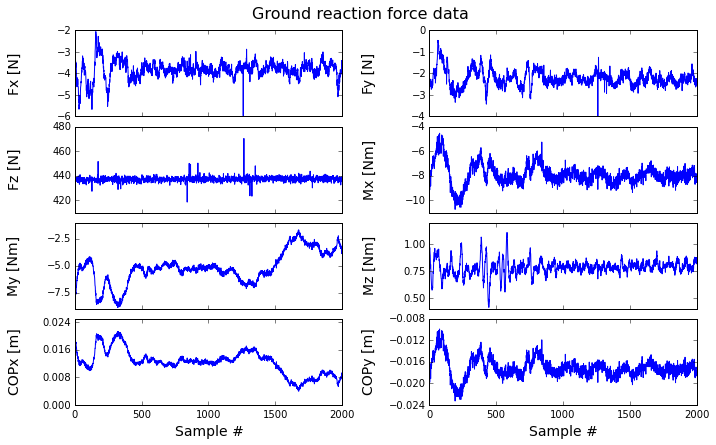

In [4]:
grf, cop = kistler_fp_cal(data[:, 1:], fxfy_range=0, fz_range=1, show=True)

## References

- [Kistler Force Plate Formulae](http://isbweb.org/software/movanal/vaughan/kistler.pdf)

## Function kistler_fp_cal.py

In [ ]:
# %load ./../functions/kistler_fp_cal.py
"""Kistler force plate calibration."""

from __future__ import division, print_function
import numpy as np
    
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'kistler_fp_cal.py v.1 2014/12/12'


def kistler_fp_cal(data, S_matrix=None, fxfy_range=0, fz_range=0, origin=None,
                   fp_type=3, show=False, axs=None):
    """Kistler force plate calibration

    In order to get proper signals of a Kistler force plate, we have to
    calibrate the acquired data according to the factory calibration (i.e.,
    transform the readed values in volts of the 8 channels to values in newtons
    for fx12, fx34, fy14, fy23, fz1, fz2, fz3, fz4) and then calculate the
    resultant forces (Fx, Fy, Fz), resultant moments of force (Mx, My, Mz),
    and center of pressure (COPx, COPy) quantities. See [1]_ and [2]_

    Parameters
    ----------
    data  : array_like [fx12, fx34, fy14, fy23, fz1, fz2, fz3, fz4]
        Kistler force plate data (8 columns, in Volts)
    S_matrix  : array_like
        sensitivity matrix for Kistler force plate (8 columns) and at least
        one row
    fxfy_range  : number [0, 1, 2, 3], optional
        Fx/Fy amplifier range used in the data acquisition
        Fx/Fy [kN]: 0.25, 1.25, 2.5, 5
        This is only used if the sensitivity matrix has more than one row
        and the first four columns of the corresponding row are selected.
    fz_range  : number [0, 1, 2, 3], optional
        Fz amplifier range used in the data acquisition
        Fz [kN]: 1, 5, 10, 20
        This is only used if the sensitivity matrix has more than one row
        and the last four columns of the corresponding row are selected.
    origin  : array_like [a, b, az0]
        coordinates of the force plate origin (az0 is negative, in meters)
    fp_type  : number [1, 2, 3, 4]
        type of force plate to be used in the COP correction  
        1: type 9281E11
        2: type 9281E and 9281EA (SN: <= 616901)
        3: type 9281E and 9281EA (SN: >= 616902)
        4: type 9287C, 9287CA
    show  : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    axs  : a matplotlib.axes.Axes instance, optional (default = None).
    
    Returns
    -------
    grf    : numpy array [Fx, Fy, Fz, Mx, My, Mz]
            ground reaction force data
    cop    : numpy array [COPx, COPy]
            center of pressure data

    References
    ----------
    .. [1] http://isbweb.org/software/movanal/vaughan/kistler.pdf
    .. [2] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/KistlerForcePlateCalculation.ipynb

    """

    if not S_matrix:
        # sensitivity matrix for Kistler force plate 9281EA Serial no. 4402018
        # calibrated range
        # Fx/Fy [kN]: 0.25, 1.25, 2.5, 5
        # Fz [kN]:    1, 5, 10, 20
        S_matrix = np.array([[38.117, 37.723, 38.062, 38.008, 19.492, 19.445, 19.426, 19.457],
                             [ 7.623,  7.545,  7.212,  7.602,  3.898,  3.889,  3.885,  3.891],
                             [ 3.803,  3.761,  3.800,  3.796,  1.951,  1.945,  1.944,  1.948],
                             [ 1.901,  1.881,  1.900,  1.898,  0.976,  0.973,  0.972,  0.974]])
    S_matrix = np.atleast_2d(S_matrix)
    S_matrix = np.hstack((S_matrix[fxfy_range, 0:4], S_matrix[fz_range, 4:9]))

    if not origin:
        # origin for Kistler force plate 9281EA Serial no. 4402018
        origin = np.array([0.120, 0.200, -0.048])
    a, b, az0 = np.hsplit(np.asarray(origin), 3)

    # COP correction coefficients
    if fp_type == 1:    # Type 9281E11
        Px = [2.51997E-15, -2.18826E-10, -2.69254E-07, -4.85912E-11, 4.55731E-6, -4.18892E-2]
        Py = [2.83750E-15, -1.00051E-10, -2.05349E-06, -1.16374E-10, 4.71553E-6, 6.89265E-2]
    elif fp_type == 2:  # Type 9281E and 9281EA (SN: <= 616901)
        Px = [1.1604E-14, -8.39091E-10, -1.44293E-6, -2.85927E-10, 2.05575E-5, -0.113525]
        Py = [1.27251E-14, -3.13238E-10, -3.33888E-6, -6.49641E-10, 1.53937E-5, 1.12624E-1]
    elif fp_type == 3:  # Type 9281E and 9281EA (SN: >= 616902)
        Px = [7.92063E-15, -5.821E-10, -2.77102E-6, -1.76083E-10, 1.29695E-5, -0.0413979]
        Py = [8.82869E-15, -2.48554E-10, -1.76282E-6, -4.22186E-10, 1.2091E-5, 5.16279E-2]
    elif fp_type == 4:  # Type 9287C, 9287CA
        Px = [1.72454E-16, -4.82275E-11, 3.30016E-7, -9.46569E-12, 2.78736E-6, -8.20399E-3]
        Py = [2.20428E-16, -1.80864E-11, -7.30249E-7, -3.03080E-11, 2.64974E-6, 5.41166E-2]
    else:
        Px = []
        Py = []

    # Calibration
    data = 1000*data/S_matrix

    fx12, fx34, fy14, fy23, fz1, fz2, fz3, fz4 = np.hsplit(data, 8)

    # Medio-lateral force
    Fx = fx12 + fx34
    # Anterior-posterior force
    Fy = fy14 + fy23
    # Vertical force
    Fz = fz1 + fz2 + fz3 + fz4
    # Plate moment about X-axis
    Mx = b * (fz1 + fz2 - fz3 - fz4)
    # Plate moment about Y-axis
    My = a * (-fz1 + fz2 + fz3 - fz4)
    # Plate moment about Z-axis
    Mz = b * (-fx12 + fx34) + a * (fy14 - fy23)
    # Plate moment about top plate surface
    Mx = Mx + Fy*az0
    # Plate moment about top plate surface
    My = My - Fx*az0
    # X-Coordinate of force application point (COP)
    ax = -My / Fz
    # Y-Coordinate of force application point (COP)
    ay = Mx / Fz
    # Coefficient of Friction x-component
    #COFx = Fx / Fz
    # Coefficient of Friction y-component
    #COFy = Fy / Fz
    # COP correction
    if Px:
        Dax = (Px[0]*ay**4 + Px[1]*ay**2 + Px[2])*ax**3 + (Px[3]*ay**4 + Px[4]*ay**2 + Px[5])*ax
        ax = ax - Dax
    if Py:
        Day = (Py[0]*ax**4 + Py[1]*ax**2 + Py[2])*ay**3 + (Py[3]*ax**4 + Py[4]*ax**2 + Py[5])*ay
        ay = ay - Day
    # Free moment
    Mz = Mz - Fy*ax + Fx*ay

    grf = np.hstack((Fx, Fy, Fz, Mx, My, Mz))
    cop = np.hstack((ax, ay))

    if show:
        _plot(grf, cop, axs)

    return grf, cop


def _plot(grf, cop, axs):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
        return

    grf = np.hstack((grf, cop))

    if axs is None:
        _, axs = plt.subplots(4, 2, figsize=(10, 6), sharex=True)

    axs = axs.flatten()
    ylabel = ['Fx [N]', 'Fy [N]', 'Fz [N]',
              'Mx [Nm]', 'My [Nm]', 'Mz [Nm]', 'COPx [m]', 'COPy [m]']
    for i, axi in enumerate(axs):
        axi.plot(grf[:, i], 'b', lw=1)
        axi.set_ylabel(ylabel[i], fontsize=14)
        axi.yaxis.set_major_locator(plt.MaxNLocator(4))
        axi.yaxis.set_label_coords(-.2, 0.5)

    axs[6].set_xlabel('Sample #', fontsize=14)
    axs[7].set_xlabel('Sample #', fontsize=14)
    plt.suptitle('Ground reaction force data', y=1.02, fontsize=16)
    plt.tight_layout(h_pad=.1)
    # plt.grid()
    plt.show()
